In [1]:
import pandas as pd 
import numpy as np
from sqlalchemy import create_engine, text
from sqlalchemy import URL
from sqlalchemy import create_engine

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
def create_table(username, password,db_name):
    url_object = URL.create(
        "mysql+mysqlconnector",
        username=username,
        password=password,
        host="localhost",
        database=db_name
    )
    return create_engine(url_object)

In [3]:
engine = create_table('root', 'Farideh@2376', 'SuperStore')

In [4]:
query = """
SELECT s.date as `shiping date` ,o.Date as `Order Date`,Sales,  discount,Quantity, `Shipping Cost`, p.Category, p.`Sub-Category`,Segment, COALESCE(returned, 0) AS returned,Market, `Ship Mode`
FROM order_detail
JOIN product p ON order_detail.`Product ID` = p.`Product ID`
JOIN shipping s ON order_detail.`Order ID` = s.`Order ID`
JOIN `order` o ON o.`Order ID` = order_detail.`Order ID`
JOIN customer c ON o.`Customer ID` = c.`Customer ID`
LEFT JOIN returned r ON order_detail.`Order ID` = r.`Order ID`;
"""


df=pd.DataFrame(engine.connect().execute(text(query)))

In [5]:
df

,shiping date,Order Date,Sales,discount,Quantity,Shipping Cost,Category,Sub-Category,Segment,returned,Market,Ship Mode
0,2011-04-05,2011-03-31,673.568,0.200,2,54.960,Office Supplies,Binders,Consumer,0,US,Standard Class
1,2011-04-05,2011-03-31,52.980,0.000,2,3.170,Office Supplies,Appliances,Consumer,0,US,Standard Class
2,2011-09-20,2011-09-15,14.940,0.000,3,0.990,Office Supplies,Paper,Consumer,0,US,Standard Class
3,2011-09-20,2011-09-15,14.560,0.000,2,1.310,Furniture,Furnishings,Consumer,0,US,Standard Class
4,2012-10-07,2012-10-04,26.960,0.000,2,5.230,Office Supplies,Storage,Consumer,0,US,First Class
...,...,...,...,...,...,...,...,...,...,...,...,...
49665,2012-08-22,2012-08-17,1127.810,0.200,3,72.710,Furniture,Chairs,Consumer,0,EU,Standard Class
49666,2012-12-03,2012-11-26,87.984,0.400,2,9.110,Furniture,Furnishings,Consumer,1,LATAM,Standard Class
49667,2013-04-29,2013-04-24,872.320,0.000,2,68.222,Technology,Phones,Consumer,0,LATAM,Second Class
49668,2014-06-21,2014-06-18,590.117,0.002,3,106.680,Technology,Copiers,Consumer,0,LATAM,Second Class


In [6]:
df['Shipping Delay'] = (df['shiping date'] - df['Order Date']).dt.days
df.drop('shiping date' ,inplace=True,axis=1)
df.drop('Order Date' ,inplace=True,axis=1)

df

,Sales,discount,Quantity,Shipping Cost,Category,Sub-Category,Segment,returned,Market,Ship Mode,Shipping Delay
0,673.568,0.200,2,54.960,Office Supplies,Binders,Consumer,0,US,Standard Class,5
1,52.980,0.000,2,3.170,Office Supplies,Appliances,Consumer,0,US,Standard Class,5
2,14.940,0.000,3,0.990,Office Supplies,Paper,Consumer,0,US,Standard Class,5
3,14.560,0.000,2,1.310,Furniture,Furnishings,Consumer,0,US,Standard Class,5
4,26.960,0.000,2,5.230,Office Supplies,Storage,Consumer,0,US,First Class,3
...,...,...,...,...,...,...,...,...,...,...,...
49665,1127.810,0.200,3,72.710,Furniture,Chairs,Consumer,0,EU,Standard Class,5
49666,87.984,0.400,2,9.110,Furniture,Furnishings,Consumer,1,LATAM,Standard Class,7
49667,872.320,0.000,2,68.222,Technology,Phones,Consumer,0,LATAM,Second Class,5
49668,590.117,0.002,3,106.680,Technology,Copiers,Consumer,0,LATAM,Second Class,3


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49670 entries, 0 to 49669
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sales           49670 non-null  float64
 1   discount        49670 non-null  float64
 2   Quantity        49670 non-null  int64  
 3   Shipping Cost   49670 non-null  float64
 4   Category        49670 non-null  object 
 5   Sub-Category    49670 non-null  object 
 6   Segment         49670 non-null  object 
 7   returned        49670 non-null  int64  
 8   Market          49670 non-null  object 
 9   Ship Mode       49670 non-null  object 
 10  Shipping Delay  49670 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 4.2+ MB


In [8]:
df.describe()

,Sales,discount,Quantity,Shipping Cost,returned,Shipping Delay
count,49670.000000,49670.000000,49670.000000,49670.000000,49670.000000,49670.000000
mean,243.840355,0.143070,3.470787,26.041125,0.059996,3.972116
std,485.963091,0.212046,2.274854,56.870281,0.237482,1.727310
min,0.444000,0.000000,1.000000,0.002000,0.000000,0.000000
25%,30.384000,0.000000,2.000000,2.580000,0.000000,3.000000
50%,83.970000,0.000000,3.000000,7.660000,0.000000,4.000000
75%,247.830000,0.200000,5.000000,23.969000,0.000000,5.000000
max,22638.500000,0.850000,14.000000,933.570000,1.000000,7.000000


In [9]:
X = df.drop(["Ship Mode"],axis=1)
y = df['Ship Mode']


In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Splitting data into train, validation and test sets with ratio of 80:10:10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,random_state=42)


In [11]:
# check the shape of X_train and X_test and X_val

X_train.shape, X_test.shape ,X_val.shape

((39736, 10), (4967, 10), (4967, 10))

In [12]:
import category_encoders as ce

#X_Train encoders
encoder = ce.OrdinalEncoder(cols=['Category','Sub-Category','Segment','Market'])
X_train= encoder.fit_transform(X_train)


#X_val encoders
X_val= encoder.transform(X_val)


#X_test encoders
X_test= encoder.transform(X_test)


In [13]:
import category_encoders as ce
#y_Train encoders

encoder = ce.OrdinalEncoder(cols=['Ship Mode'])
y_train= encoder.fit_transform(y_train)


#y_val encoders
y_val= encoder.transform(y_val)


#y_test encoders
y_test= encoder.transform(y_test)

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MaxAbsScaler

columns_to_scale = [ 'Sales', 'Shipping Cost','Quantity','Sub-Category']

#X_train scale
scaler = QuantileTransformer()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_train.head(5)

#X_val scale
X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
X_val.head(5)

#X_test scale
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

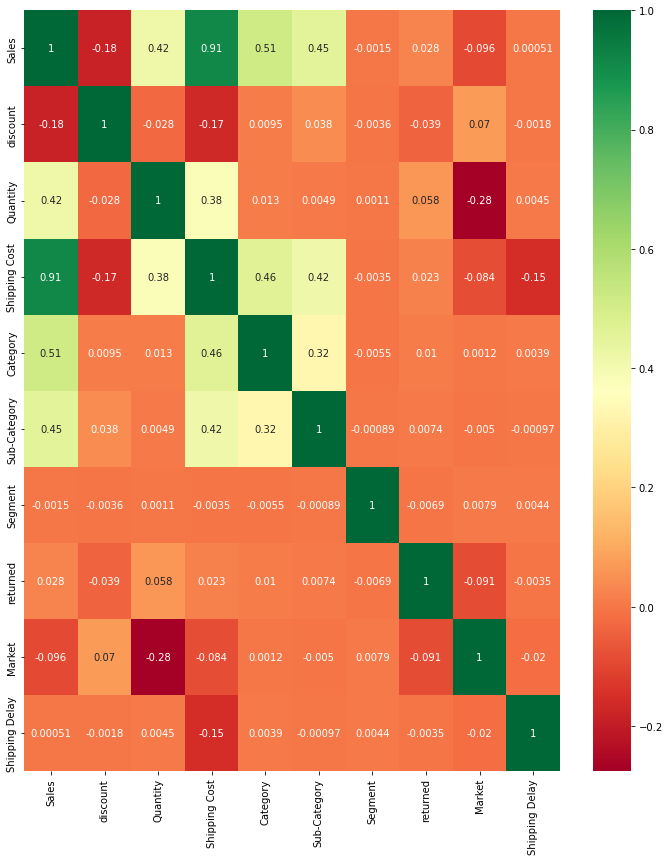

In [15]:
plt.figure(figsize=(12,14))
sns.heatmap(X_train.corr(),annot=True,cmap='RdYlGn');

# KNeighborsClassifier

In [16]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,40)}

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])})

In [19]:
print("Best parameters:", knn_cv.best_params_)
print("Best Score:", knn_cv.best_score_)

Best parameters: {'n_neighbors': 36}
Best Score: 0.8123866191019277


In [20]:
from sklearn.metrics import recall_score, precision_score, f1_score , accuracy_score
score_knn=knn_cv.best_score_
model_knn = KNeighborsClassifier(n_neighbors=36 )
model_knn.fit(X_train,y_train)
y_pred_knn = model_knn.predict(X_val)

f1_score_knn = f1_score(y_val, y_pred_knn, average='macro') 
recall_knn = recall_score(y_val, y_pred_knn, average='macro') 
accuracy_knn = accuracy_score(y_val, y_pred_knn)
precision_knn = precision_score(y_val, y_pred_knn, average='macro') 


print(f'\033[96m')
print('accuracy_knn   : ', accuracy_knn.round(4))
print('f1_score       : ', f1_score_knn.round(4))
print('recall_knn     : ', recall_knn.round(4))
print('precision_knn  : ', precision_knn.round(4))


accuracy_knn   :  0.8071
f1_score       :  0.736
recall_knn     :  0.7214
precision_knn  :  0.7618


# DecisionTreeClassifier

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5)
}

# create a Decision Tree classifier instance
dtree = DecisionTreeClassifier()

# create a GridSearchCV object and fit it to the data
grid_search = GridSearchCV(dtree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.8162622511278641


In [24]:
decision_tree = DecisionTreeClassifier( criterion='gini', max_depth=4 ,min_samples_leaf=1, min_samples_split=2)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [26]:
y_pred_DecisionTree = decision_tree.predict(X_val)


f1_score_DecisionTree = f1_score(y_val, y_pred_DecisionTree, average='macro') 
recall_DecisionTree = recall_score(y_val, y_pred_DecisionTree, average='macro') 
accuracy_DecisionTree = accuracy_score(y_val, y_pred_DecisionTree)
precision_DecisionTree = precision_score(y_val, y_pred_DecisionTree, average='macro') 

print(f'\033[92m')
print('accuracy_DecisionTree   : ', accuracy_DecisionTree.round(4))
print('f1_score_DecisionTree   : ', f1_score_DecisionTree.round(4))
print('recall_DecisionTree     : ', recall_DecisionTree.round(4))
print('precision_DecisionTree  : ', precision_DecisionTree.round(4))


accuracy_DecisionTree   :  0.8136
f1_score_DecisionTree   :  0.7467
recall_DecisionTree     :  0.7303
precision_DecisionTree  :  0.7743


# RandomForestClassifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
'criterion': ['gini', 'entropy'],
'max_depth': [3,10,14],
'min_samples_split': [3,8,12],
'min_samples_leaf':[3,9,18],
'n_estimators': [50, 100, 150, 200]
}

rfc = RandomForestClassifier()

grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)
score_RandomForest=grid_search.best_score_
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 18, 'min_samples_split': 12, 'n_estimators': 200}
Best score: 0.821396206967283


In [29]:
RandomForest=RandomForestClassifier(criterion='entropy',max_depth=14,min_samples_leaf=18, min_samples_split=12,n_estimators=20)
RandomForest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_leaf=18,
                       min_samples_split=12, n_estimators=20)

In [30]:
score_RandomForest=grid_search.best_score_

y_pred_RandomForest = RandomForest.predict(X_val)


f1_score_RandomForest = f1_score(y_val, y_pred_RandomForest, average='macro') 
recall_RandomForest = recall_score(y_val, y_pred_RandomForest, average='macro') 
accuracy_RandomForest = accuracy_score(y_val, y_pred_RandomForest)
precision_RandomForest = precision_score(y_val, y_pred_RandomForest, average='macro') 

print(f'\033[92m')
print('accuracy_RandomForest  : ', accuracy_RandomForest.round(4))
print('f1_score_RandomForest  : ', f1_score_RandomForest.round(4))
print('recall_RandomForest    : ', recall_RandomForest.round(4))
print('precision_RandomForest : ', precision_RandomForest.round(4))


accuracy_RandomForest  :  0.819
f1_score_RandomForest  :  0.7539
recall_RandomForest    :  0.7423
precision_RandomForest :  0.7822


# Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

# define parameter grid
param_grid = {'C': [0.1, 1],
              'gamma': [1, 0.1],
              'kernel': ['rbf',  'sigmoid']}

# create a SVM model
svm_model = SVC()

# create GridSearchCV object
grid_search = GridSearchCV(svm_model, param_grid, cv=5)

# fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: {:.2f}%".format(grid_search.best_score_*100))

In [31]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')

svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_val)


f1_score_svm = f1_score(y_val, y_pred_svm, average='macro') 
recall_svm = recall_score(y_val, y_pred_svm, average='macro') 
accuracy_svm = accuracy_score(y_val, y_pred_svm)
precision_svm = precision_score(y_val, y_pred_svm, average='macro') 

print(f'\033[92m')
print('accuracy_svm  : ', accuracy_svm.round(4))
print('f1_score_svm  : ', f1_score_svm.round(4))
print('recall_svm    : ', recall_svm.round(4))
print('precision_svm : ', precision_svm.round(4))


accuracy_svm  :  0.7995
f1_score_svm  :  0.7234
recall_svm    :  0.7103
precision_svm :  0.7474


# LogisticRegression

In [34]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.1, 1],
'solver': ['lbfgs', 'liblinear', 'sag'],
'max_iter': [100, 200]}

lr_model = LogisticRegression()

grid_search = GridSearchCV(lr_model, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best parameters : ", grid_search.best_params_)
print("Best score      :" , grid_search.best_score_)

Best parameters :  {'C': 1, 'max_iter': 100, 'solver': 'liblinear'}
Best score      : 0.7951982905875734


In [35]:
LogisticRegr=LogisticRegression(C= 1, max_iter= 100, solver= 'liblinear')


# fit the model
LogisticRegr.fit(X_train, y_train)


y_pred_LogisticRegr=LogisticRegr.predict(X_val)



f1_score_LogisticRegr = f1_score(y_val, y_pred_LogisticRegr, average='macro') 
recall_LogisticRegr = recall_score(y_val, y_pred_LogisticRegr, average='macro') 
accuracy_LogisticRegr = accuracy_score(y_val, y_pred_LogisticRegr)
precision_LogisticRegr = precision_score(y_val, y_pred_LogisticRegr, average='macro') 


print(f'\033[92m')
print('accuracy_LogisticRegr  : ', accuracy_LogisticRegr.round(4))
print('f1_score_LogisticRegr  : ', f1_score_LogisticRegr.round(4))
print('recall_LogisticRegr    : ', recall_LogisticRegr.round(4))
print('precision_LogisticRegr : ', precision_LogisticRegr.round(4))


accuracy_LogisticRegr  :  0.7916
f1_score_LogisticRegr  :  0.7146
recall_LogisticRegr    :  0.6998
precision_LogisticRegr :  0.7457


In [36]:
 models = pd.DataFrame({
    
    'Model': [
        'KNeighborsClassifier', 'DecisionTreeClassifier',
        'RandomForestClassifier', 'Support Vector Machine',
        'Logistic Regression Classifier '
    ],
    
    'accuracy': [
        accuracy_knn, accuracy_DecisionTree,
        accuracy_RandomForest, accuracy_svm,
        accuracy_LogisticRegr
    
    ],
    
    'f1_score': [
         f1_score_knn, f1_score_DecisionTree,
        f1_score_RandomForest, f1_score_svm,
        f1_score_LogisticRegr
    ]
})
models

,Model,accuracy,f1_score
0,KNeighborsClassifier,0.807127,0.735956
1,DecisionTreeClassifier,0.813570,0.746700
2,RandomForestClassifier,0.819005,0.753935
3,Support Vector Machine,0.799477,0.723355
4,Logistic Regression Classifier,0.791625,0.714645


In [37]:
models.sort_values(by='f1_score', ascending=False).style.background_gradient(
        cmap='coolwarm').hide_index().set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

Model,accuracy,f1_score
RandomForestClassifier,0.819005,0.753935
DecisionTreeClassifier,0.813570,0.746700
KNeighborsClassifier,0.807127,0.735956
Support Vector Machine,0.799477,0.723355
Logistic Regression Classifier,0.791625,0.714645


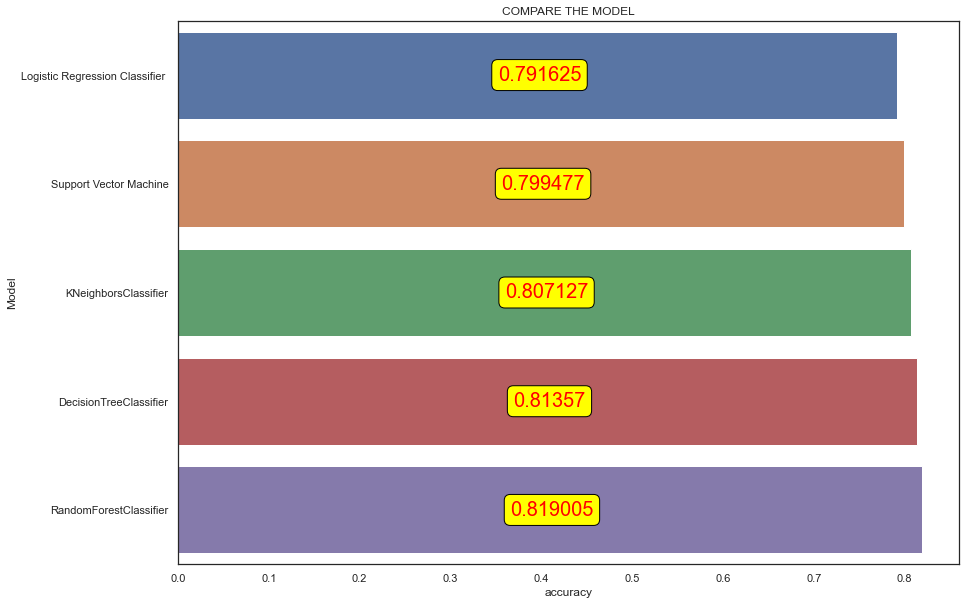

In [38]:
p = plt.figure(figsize=(14,10))

p = sns.set_theme(style="white")

p= models=models.sort_values(by='f1_score',ascending=True)[:20]

p = sns.barplot(y= 'Model', x= 'accuracy', data= models)

for container in p.containers:
    p.bar_label(container,label_type = 'center',padding = 2,size = 20,color = "Red",rotation = 0,
    bbox={"boxstyle": "round", "pad": 0.3, "facecolor": "yellow", "edgecolor": "black", "alpha": 1})
plt.title('COMPARE THE MODEL')
plt.xlabel('accuracy')
plt.ylabel('Model');

# Best Performing Model : RandomForestClassifier

In [47]:
prediction =  RandomForest.predict(X_test)
prediction


array([2, 3, 2, ..., 2, 4, 1])

In [40]:
y_test = y_test.to_numpy().flatten()
y_test

array([2, 3, 2, ..., 2, 4, 1])

In [43]:
cross_checking = pd.DataFrame({'Actual' : y_test, 'Predicted' : prediction.ravel()})
cross_checking.sample(10)

,Actual,Predicted
508,1,1
2197,1,2
1581,2,2
4543,2,2
650,3,1
3091,1,2
932,2,2
528,4,4
4134,2,2
3401,3,3


In [44]:
cross_checking.sample(10).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

,Actual,Predicted
4158,2,2
3165,4,4
295,2,2
1979,1,1
4260,2,2
630,2,2
419,2,2
1881,4,4
1491,2,2
2303,1,2


In [45]:
cross_checking.to_csv('cross_checking_Classifier.csv', index=False)

In [46]:
sorted_models = models.sort_values(by='accuracy', ascending=False)  #
sorted_models.to_csv('modelsClassifier.csv', index=False)